<a href="https://colab.research.google.com/github/Celesu/My-Journey/blob/main/My%20Intern's%20Output/OCR_untuk_Sertifikat_LP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bagian Pembuka**

Bagian ini berisikan beberapa sistem yang dibutuhkan untuk menjalankan fungsi yang telah dibentuk. 

Sistem yang dimaksud akan diunduh pada *Environment* ini sehingga hanya bersifat sementara (maka ketika anda ingin menggunakan *Environment* ini, anda akan mengunduh sistemnya lagi), besar sistem ini kurang lebih *25mb.*

Anda dapat menjalankan sel di bawah ini dengan cara menekan tanda *play* di bawah ini.

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install pdf2image
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 11 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 3s (1,619 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
import cv2
import pytesseract
import os
import pandas as pd
import re

from PIL import Image
from pdf2image import convert_from_path 
from google.colab import drive
from google.colab import files

In [ ]:
pd.options.display.max_colwidth = 1000

In [ ]:
def file_upload(x, y="/content/", z=0):
  img_form = convert_from_path(y + x)      
  H = 0
  L = 0
  empty = ['-', '-', '-', '-', x]
  for i in img_form: #ambil tiap halaman dari pdf
      filename = "/tmp/pdf_as_img.jpg"
      i.save(filename, 'JPEG')       
      width, height = i.size
      if width < height: #Untuk gambar yang posisinya vertikal
        i = i.rotate(270, expand=True)

      if height < 1700:
        return print("File ", x, " adalah Lampiran")

      k = 0
      
      text = pytesseract.image_to_string(i)
      text = text.split("\n")
      for ii in text:

        # ------------- FILTER KODE LP -------------
        #Filter ke-1 untuk kode LP
        x_lp = re.search("^LP-", ii)          
        if x_lp and L != 1:
          empty[0] = ii
          L = 1
          
        #Filter ke-2 untuk kode LP
        #untuk kasus dimana tulisan LP-..., yang terbaca hanya P-...
        x_lp = re.search("^P-", ii)
        if x_lp and L != 1:
          ii = "L" + ii
          empty[0] = ii
          L = 1
          
        #Filter ke-3 untuk kode LP
        #untuk kasus dimana tulisan LP tidak terbaca atau yang lain
        x_lp = re.search("^SERTIFIKAT AKREDITASI", ii)
        for j in text[k+1:]:
          if j != " " and j != "" and ((re.search("^[0-9]", j) and re.search("-IDN", j)) or re.search("LP-", j)) and L != 1:
            kk = 0
            if j.split(" ")[0] != "LP" and re.search("^[A-Za-z]", j):
              for l in j.split(" "):           
                if re.search("^LP-", l):
                  if len(j.split(" ")) == 1:
                    empty[0] = l
                  elif j.split(" ")[kk + 1] == "(Amd)" or j.split(" ")[kk + 1] == "(Amd)*":
                    empty[0] = l + " " + j.split(" ")[kk + 1]
                  break
                kk += 1
            elif re.search("^LP-", j.split(" ")[0]):
              empty[0] = j
            elif re.search("^[0-9]", j) and re.search("-IDN", j):  #untuk yang tulisan LP tidak terdeteksi
              empty[0] = "LP-" + j
            elif re.search("LP-", j): #untuk yang karakter (; atau :) yang ada karena desain background sertifikat
              kk = 0
              for l in j.split(" "):
                if re.search("^LP-", l):
                  if len(j.split(" ")) == 1:
                    empty[0] = l
                  elif j.split(" ")[kk + 1] == "(Amd)" or j.split(" ")[kk + 1] == "(Amd)*":
                    empty[0] = l + " " + j.split(" ")[kk + 1]
                  break
                kk += 1
            L = 1
            break

        #-------------- Filter bahasa -------------

        if re.search("expiry", ii): #untuk setifikat berbahasa Inggris
          #Filter ke-1 untuk nama LPK dalam sertifikat berbahasa inggris
          #yaitu ketika kata "Diberikan kepada" berubah menjadi "Granted to"
          #dengan ide yang serupa dari Filter ke-2 untuk nama LPU dalam sertifikat.
          x_nama_lpu = re.search("Granted to$", ii)
          if x_nama_lpu and H !=1:
              l = k+1
              for j in text[k+1:]:
                  x = re.search("^[A-Z]", j)
                  l += 1
                  if x:
                    for jj in text[l:]:
                      if jj == " " or jj == "at":
                        break 
                      elif jj == "\n":
                        if re.search("at", text[l+1]):
                          break
                        elif re.search("^[A-Za-z]", text[l+1]):
                          j = j + " " + text[l+1]
                          break
                      else:
                        j = j + " " + jj
                        break
                  break
              empty[2] = j
              H = 1

          #Filter ke-2 untuk nama LPK dalam sertifikat berbahasa inggris
          #untuk kasus yang serupa pada filter ke-1
          if H != 1: 
              x_nama_lpu = re.search("expiry", ii)
              if x_nama_lpu:
                l = k+1
                for j in text[k+1:]:
                    x = re.search("^[A-Z]", j)
                    l += 1
                    if (x or (j.split(" ")[0] == "|" and re.search("[A-Za-z]", j))) and j.split(" ")[0] != "Granted":
                      for jj in text[l:]:
                        if jj == "\n" or jj == "" or jj.split(" ")[0] == "at":
                          break 
                        j = j + " " + jj
                      break
                H = 1 #Agar tidak mengulang 2x       
                empty[2] = j

          #Filter Masa Berlaku
          #Filter untuk masa berlaku dalam sertifikat berbahasa inggris
          #serupa dengan filter sebelumnya, hanya saja kata yang dimaksud 
          #menjadi "Date of expiry".
          x_tgl = re.search("Date of expiry", ii) 
          if x_tgl:
            for i in range(len(ii.split(" "))):
              if re.search("expiry", ii.split(" ")[i]):
                  break
            ii = " ".join(ii.split(" ")[i-2:])
            empty[1] = ii

        else: #Untuk sertifikat berbahasa Indonesia
          # ------------- FILTER NAMA LPK -------------
          #Filter ke-1 untuk nama LPK dalam sertifikat
          #untuk kasus ketika posisi "Diberikan kepada" berada di tengah-tengah
          #antara tanggal sertifikat mulai berlaku dan 
          #tanggal sertifikat berakhir.
          if H != 1: 
              x_nama_lpu = re.search("^Tanggal", ii)
              if x_nama_lpu:
                l = k+1
                for j in text[k+1:]:
                    if j.split(" ")[0] == "|":
                      j = " ".join(j.split(" ")[1:])

                    x = re.search("^[A-Z]", j)
                    l += 1
                    if x and j.split(" ")[0] != "Diberikan":
                      for jj in text[l:]:
                        if re.search("di", jj):
                          break 
                        elif jj == "\n" or jj == "":
                          if re.search("di", text[l+1]):
                            break
                          elif re.search("^[A-Za-z]", text[l+1]):
                            j = j + " " + text[l+1]
                            break
                        else:
                          j = j + " " + jj
                          break
                      break
                H = 1 #Agar tidak mengulang 2x       
                empty[2] = j

          #Filter ke-2 untuk nama LPK dalam sertifikat
          #untuk kasus ketika posisi "Diberikan kepada" berada di bawah
          #posisi tanggalan (seperti masa berlaku, tanggal diperbarui, atau
          #tanggal sertifikat mulai berlaku).
          x_nama_lpu = re.search("berikan kepada", ii) #Karena ada beberapa pdf yang tulisan "Diberikan kepada" tidak terbaca sepenuhnya  
          if x_nama_lpu and H != 1:
              l = k+1
              for j in text[k+1:]:
                  x = re.search("^[A-Z]", j)
                  l += 1
                  if (x or (j.split(" ")[0] == "|" and re.search("[A-Za-z]", j))) and j.split(" ")[0] != "Berlaku" and j.split(" ")[0] != "Tanggal":
                    for jj in text[l:]:
                      if jj == "\n" or jj == "" or re.search("di", jj):
                        break 
                      j = j + " " + jj
                    break
              empty[2] = j
              H = 1 #Pembeda untuk filter ke-1 agar tidak 2x teproses
    

          # ------------- FILTER MASA BERLAKU -------------
          #Filter untuk masa berlaku dalam sertifikat                
          #dengan mengambil baris yang berisi kata "Berlaku hingga".
          x_tgl = re.search("Berlaku hingga", ii)
          if x_tgl:
            for i in range(len(ii.split(" "))):
              if re.search("Berlaku", ii.split(" ")[i]):
                  break
            ii = " ".join(ii.split(" ")[i:])
            empty[1] = ii

        #-------------- Filter bahasa telah selesai -------------
          
        # ------------- FILTER Standar Kompetensi -------------
        #Filter ke-1 untuk mendapatkan kode standar kompetensi pada sertifikat
        x_sni = re.search("^SNI", ii)            
        if x_sni:
          empty[3] = ii
          break

        k += 1  #posisi baris saat ini
      
  for i in range(len(empty)): #Buang karakter yang tdk berarti
      empty[i] = empty[i].replace(" |", "")
      empty[i] = empty[i].replace("| ", "")
      if i == 1:
        empty[i] = " ".join(empty[i].split(" ")[-3:]) #yang diambil hanya tgl saja
        
  if z == 0:       
    return empty, print("\nKode LP: ", empty[0], "\nNama LPK: ", empty[2], "\nBerlaku Hingga: ", empty[1], "\nStandar Kompetensi: ", empty[3], "\nNama File: ", empty[-1])
  elif z == 1:
    return empty

In [ ]:
def file_gdrive(x): #x: path gdrive
  my_df = pd.DataFrame(columns = ["Kode LP", "Nama LPK", "Berlaku Hingga", "Standar Kompetensi", "Nama File"])
  print("Sedang diproses")
  for h in os.listdir(x):
    if h.split(".")[-1] == "pdf" and h.split("-")[0] != "LK":
      base_dir = x
      empty = file_upload(h, base_dir, z=1)
      
      my_dictionary = {"Kode LP": empty[0], "Nama LPK": empty[2], 
                      "Berlaku Hingga": empty[1], "Standar Kompetensi": empty[3],
                       "Nama File": empty[-1]}

      my_df = my_df.append(my_dictionary, ignore_index = True)
      
  my_df['i'] = my_df['Kode LP'].str.split("-", n=2, expand=True)[1].astype(int)
  my_df = my_df.sort_values('i').reset_index(drop=True)
  my_df.drop(columns=['i'], inplace=True)
  my_df.index += 1
  print("Proses selesai, silahkan lanjut ke sel berikutnya")
  return my_df

In [ ]:
def download_the_output(x):
  save_dir = "/content/sample_data/" + x.split("/")[-1] + ".xlsx"
  output.to_excel(save_dir, index=False, header=True)
  return files.download(save_dir)

# **Bagian untuk upload file satuan**
Untuk menjalankan kode/sel di bawah ini anda dapat menekan tombol **SHIFT + ENTER** atau tanda *play* yang ada.

Lalu upload file **Sertifikat Lab Penguji** yang anda ingin dapatkan datanya.
Anda dapat mengklik tulisan **Pilih File** atau anda dapat *drag* file tersebut dari dokumen anda ke baris yang seperti gambar di bawah (yang muncul setelah anda menjalankan sel di bawah ini).

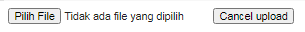





In [ ]:
file = files.upload()
for i in file.keys():
  the_pdf = i

Saving LP-638-IDN_Amd_2019.pdf to LP-638-IDN_Amd_2019.pdf


Lalu anda dapat menekan tombol **CTRL + ENTER** atau menekan tanda *play* pada sel di bawah ini untuk mendapatkan output yang diinginkan


In [ ]:
_ = file_upload(the_pdf)


Kode LP:  LP-638-IDN (Amd)* 
Nama LPK:  Pusat Pendayagunaan Informatika dan Kawasan Strategis Nuklir - BATAN 
Berlaku Hingga:  17 Januari 2021 
Standar Kompetensi:  SNI ISO/IEC 17025:2017 (ISO/IEC 17025:2017) 
Nama File:  LP-638-IDN_Amd_2019.pdf


# **Bagian untuk mendapatkan data dari G-Drive**
Untuk menjalankan kode/sel di bawah ini, anda apat menekan tombol **SHIFT + ENTER** secara bersamaan. 

Lalu anda dapat klik *link* yang diberikan, lalu pilih akun **SistemLab KAN** dan klik izinkan daripada beberapa permintaan dari Google, lalu *copy* kode yang diberikan dan *paste* kode tersebut pada box yang diberikan.

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


Karena ini merupakan kode untuk **Sertifikat LP** maka untuk sel di bawah ini, tepatnya **pdf_dir** tidak diubah-ubah, jika ingin mengekstrak data dari file **Ttd basah** atau **ttd esign**, anda dapat mengetik nama file tersebut (menjadi "Ttd basah/" atau "ttd esign/" [tanda " / " harus ada] atau *tidak diubah sama sekali* untuk mengakses data **Sertifikat LP** pada file **Sertifikat ALP**) pada baris **tujuan**. Lalu anda dapat melanjutkannya dengan menekan tombol **CTRL + ENTER** pada sel di bawah ini.

In [ ]:
tujuan = "" 
pdf_dir = "/content/drive/My Drive/Sertifikat ALP/" + tujuan

Untuk dua sel di bawah ini, anda tidak perlu merubah apapun, anda hanya perlu mengklik sel tersebut, lalu tekan tombol **SHIFT + ENTER** sebanyak *2x* dan tunggu pdf hingga selesai diproses. Hasil yang didapatkan berupa *Data frame* dari output yang didapat.


*Note:*

Untuk file yang berjumlah kurang dari 50 file pdf, waktu yang dibutuhkan kurang lebih sekitar 1-5 menit.

sedangkan untuk file yang jumlahnya lebih dari 100 file pdf, waktu yang dibutuhkan lebih dari 10 menit, maka anda dapat melakukan hal lain sambil menunggu file selesai diproses.

In [ ]:
output = file_gdrive(pdf_dir)

Sedang diproses
Proses selesai, silahkan lanjut ke sel berikutnya


In [ ]:
pd.set_option('display.max_rows', output.shape[0]+1)
output

,Kode LP,Nama LPK,Berlaku Hingga,Standar Kompetensi,Nama File
1,LP-621-IDN (Amd)*,Balai Riset dan Standardisasi Industri Medan,17 Januari 2021,SNI ISO/IEC 17025:2017 (ISO/IEC 17025:2017),LP 621 IDN AMD 2019.pdf
2,LP-623-IDN (Amd)*,"Laboratorium Cabang Palembang, PT Sucofindo (Persero)",18 Oktober 2020,SNI ISO/IEC 17025:2017 (ISO/IEC 17025:2017),LP 623 IDN_AMD_2019.pdf
3,LP-624-IDN (Amd)*,Balai Besar Perbenihan dan Proteksi Tanaman Perkebunan Medan,24 Oktober 2021,SNI ISO/IEC 17025:2017 (ISO/IEC 17025:2017),LP 624 IDN_Amd_2019.pdf
4,LP-625-IDN,"Laboratorium Cabang Pekanbaru, PT Sucofindo",13 Juni 2021,SNI ISO/IEC 17025:2008 (ISO/IEC 17025:2005),625_2017.pdf
5,LP-626-IDN (Amd)*,Balai Teknik Kesehatan Lingkungan dan Pengendalian Penyakit Kelas I Batam,25 Juli 2021,SNI ISO/IEC 17025:2017 (ISO/IEC 17025:2017),626_2018Penyesuaian.pdf
6,LP-627-IDN (Amd)*,PT Medialab Indonesia,26 Desember 2020,SNI ISO/IEC 17025:2017 (ISO/IEC 17025:2017),LP 627 IDN AMD 2019.pdf
7,LP-628-IDN (Amd)*,"Stasiun Karantina Ikan, Pengendalian Mutu dan Keamanan Hasil Perikanan Pontianak",26 Februari 2021,SNI ISO/IEC 17025:2017 (ISO/IEC 17025:2017),LP 628 IDN_AMD2019.pdf
8,LP-630-IDN (Amd)*,Balai Karantina Pertanian Kelas I Palembang,22 November 2020,SNI ISO/IEC 17025:2017 (ISO/IEC 17025:2017),LP-630-IDN_Amd_2019.pdf
9,LP-631-IDN,Regional Central Laboratory Balaraja — PT Charoen Pokphand Indonesia,27 Oktober 2020,SNI ISO/IEC 17025:2008 (ISO/IEC 17025:2005),631_2016.pdf
10,LP-632-IDN (Amd)*,PT Charoen Pokphand Indonesia — Regional Central Laboratory Medan,21 Juni 2020,SNI ISO/IEC 17025:2017 (ISO/IEC 17025:2017),LP 632 IDN_amd2019.pdf


Tabel di atas merupakan *Data frame* dari output yang didapat.

Selanjutnya, sel di bawah merupakan bagian untuk mengunduh file output dari *Data frame* yang didapatkan ke komputer anda.

Jika anda berniat untuk mengunduh, anda dapat menekan tombol **SHIFT + ENTER** pada sel di bawah ini.

In [ ]:
download_the_output(pdf_dir)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>